# Home assignement 1

This tutorial investigates deterministic signals and the design of digital filters.
To do this assignement we need a Python 3 distribution with the following libraries:

In [1]:
# import numpy for array manipulation and fft
import numpy as np
#import classical constant pi form numpy to avoid namespace
from numpy import pi
# import filtering functionalities from scipy.signal
from scipy.signal import lfilter, filtfilt, butter, freqs, freqz
# plotting functionalities
from scipy.integrate import ode
# simulation functionalities
import matplotlib.pyplot as plt


If you want to give back the assignement as a jupyter notebook, the following command triggers inline plot.

## Modeling of post-synaptic potentials (PSP)

We will study a linear model of the post-synaptic potential of a neuronal membrane. The pre-synaptic input to this neuron will be denoted $x(t)$, and the output membrane potential $y(t)$. 

We use a first order differential equation to model the input output relationship. This relies neglecting many non-linearities, and assuming $x(t)$ directly reflects the post-synaptic current flowing through the membrane with capacitance $C$ (due to charge accumulation on both sides of the membrane) and resistance $R$ (modeling the leak currents flowing through various ion channels).

This results in the differential equation:

$$C\frac{dy}{dt}(t)+\frac{1}{R}y(t)= x(t)$$

To simplify notation we will assume $R=1$ such that the above equation is only controlled by the membrane time constant $\tau=RC$ and can be rewritten

$$\tau\frac{dy}{dt}(t)+y(t)= x(t)$$



# Part 1: Analog filter

## Simulation with ODE solver

Such ordinary differential equation (ODE) can be simulated on a computer using scipy.integrate.ode, which is a wrapper for solving initial value problems of dynamical systems. To apply such routine, we put the equation in the form

$$\frac{dy}{dt}(t)= \frac{1}{\tau}\left(x(t)-y(t)\right)=f_x(y,t)$$

such that we can estimate the response to different inputs $x(t)$ by redefining the function $f_x$. We define this function with $\tau=20ms$, such that we can pass an arbitrary function of time for $x$ as third argument:

In [2]:
tau = .02
def f_x(t,y,x,tau):
    return 1/tau*(x(t)-y)

In addition, to the differential equation, solving for $y$ requires providing an initial value $y_0$ such that $y(t_0)=y_0$ for a given initial time point $t_0$. In order to unambiguously define the output of the system without further consideration for this initial value, we will always assume $y_0=0$ and choose $t_0$ such that $x(t)=0$ for all $t<t_0$. Under such assumption, the output of the system is a signal $y(t)$ such that $y(t)=0$ for all $t<t_0$, and for $t\geq t_0$, $y(t)$ is provided by the solution of the initial value problem defined above.

We will take for granted that the output $y$ can be computed for time axis $t$ using the  *filterOutput* function defined below:

In [3]:
def filterOutput(t,x,dt=.02):
    '''
    computes output values for the synapse model
    inputs:
        t - a 1 dimensional numpy array of time points at which values should be computed
        x - a function take one float input argument (the time)
        dt - simulation time step
    outputs:
        y - a 1 dien  sional numpy array of values of y(t) for each input time point
    '''
    r = ode(f_x,None)
    r.set_integrator('dopri5')
    r.set_initial_value(0,t[0])
    r.set_f_params(x, tau)
    y = []
    for k in range(t.shape[0]):
        y.append(r.integrate(r.t+dt))
        
    return np.array(y)


The post-synaptic response in real neurons is triggered by afferent (pre-synaptic) action potentials. To model this, we define a triangular spike waveform parameterized by a spike width T (in seconds).

In [4]:
def spikeWaveform(t,T):
    spkWave = (np.abs(t)<T).astype(np.float)*(1-np.abs(t)/T)/T
    return spkWave


We will assume a spike duration of $1ms$ and fix the spike(t) function accordingly

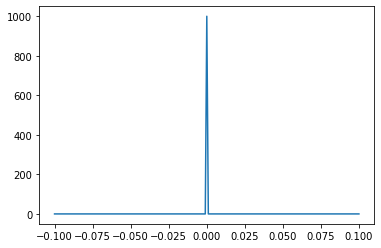

In [5]:
T = .001
dt=.0001
spike = lambda t: spikeWaveform(t,T)
t = np.arange(-.1,.1,dt)
plt.plot(t,spike(t))

**Question 1:**
 - (a) Compute the response of the above defined synapse to spike(t), using the above function, for a time axis ranging from $-10ms$ to $100ms$, with a sampling period $dt=0.1ms$ (unless otherwise stated, $dt$ takes this value for all other questions). (1)

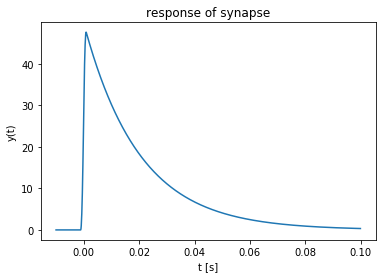

In [6]:
T = 0.001
dt=0.0001
spike = lambda t: spikeWaveform(t,T)
t = np.arange(-0.01,0.1,dt)

y=filterOutput(t,spike,dt)

# plot
plt.figure(figsize=(6,4))
plt.plot(t,y)
plt.title('response of synapse')
plt.xlabel('t [s]')
plt.ylabel('y(t)')
plt.show()

 - (b) From the lecture, find the analytical expression of the impulse response of the system with input x and output y, plot this response. Also provide the tranfer function of the system based on the Laplace transform. (1)

<img src="q1.jpg" align="left" width=800 height=600 />

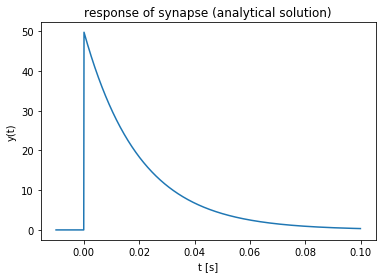

In [7]:
analytical_y = lambda t :(t >= 0) * 1/tau * np.exp(-t/tau)

# plot
plt.figure(figsize=(6,4))
plt.plot(t,analytical_y(t))
plt.title('response of synapse (analytical solution)')
plt.xlabel('t [s]')
plt.ylabel('y(t)')
plt.show()


 - (c) Compare plots in (a) and (b), and based on that argue which well-known distribution  $spike(t)$ approximates in the context of this simulation. (1)

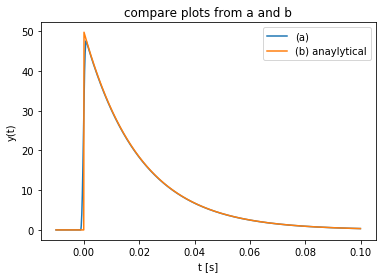

In [8]:
# plot
plt.figure(figsize=(6,4))
plt.plot(t,y,label='(a)')
plt.plot(t,analytical_y(t),label='(b) anaylytical')
plt.title('compare plots from a and b')
plt.xlabel('t [s]')
plt.ylabel('y(t)')
plt.legend()
plt.show()

$spike(t)$ is the $x(t)$ in $\frac{dy}{dt}(t)= \frac{1}{\tau}\left(x(t)-y(t)\right)$, it has spike width of 1 ms and max value of 1000 at t=0, so $\int spike(t) \, dt = 1$ ,and all mass is within the -1 ms to 1 ms time window, therefore $spike(t)$ is approximating a dirac delta function.

**Question 2:**
 - (a) We define the *current clamp* experiments as setting $x(t)= 1$ (from an original value of $0$ for $t<0$) for the duration $0\leq t\leq D$ with $D=100ms$, before setting back $x(t)=0$ for $t>D$. Compute and plot the output y(t) for such experiment for t ranging from $-10ms$ to $200ms$. (1)

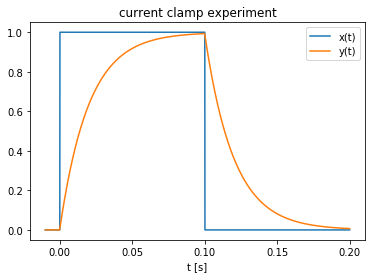

In [9]:
t = np.arange(-0.01,0.2,dt)
c_clamp = lambda t: (t>=0) & (t<=0.1)
y2=filterOutput(t,c_clamp,dt)

# plot
plt.figure(figsize=(6,4))
plt.plot(t,c_clamp(t),label='x(t)')
plt.plot(t,y2,label='y(t)')
plt.title('current clamp experiment')
plt.xlabel('t [s]')
plt.legend()
plt.show()


 - (b) In order to study analytically the first part of the response ($t<D$), we observe that the input on this range is identical to a unit step Heaviside function $u(t)$. Given, that the Laplace transform of $u(t)$ is $U(p)=\frac{1}{p}$, compute the Laplace transform of the output $Y(p)$. (1)

<img src="q2b.jpg" align="left" width=600 height=600 />

 - (c) Reduce the expression of $Y$ to a form $Y(p)=\frac{A}{p}+\frac{B}{1+\tau p}$ by reducing this expression to a common denominator and identifying the parameters. (2)

<img src="q2c.jpg" align="left" width=600 height=600 />

 - (d) Using (c) and the linearity of the Laplace transform, retrieve the analytic expression of the response in the time domain $y(t)$. Plot the analytical expression and check consistency with the response computed in (a), for the range $t<D$. (2)

<img src="q2d.jpg" align="left" width=600 height=600 />

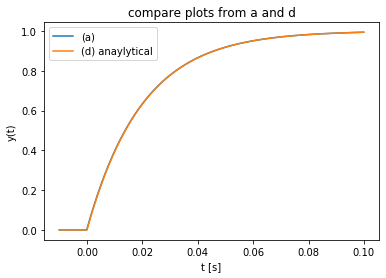

In [10]:
t = np.arange(-0.01,0.1,dt)
analytical_y2 = (t>=0)*(1-np.exp(-t/tau))

# plot
plt.figure(figsize=(6,4))
plt.plot(t,y2[0:len(t)],label='(a)')
plt.plot(t,analytical_y2,label='(d) anaylytical')
plt.title('compare plots from a and d')
plt.xlabel('t [s]')
plt.ylabel('y(t)')
plt.legend()
plt.show()

We now study the frequency properties of this system.

**Question 3:**

 - (a) Compute the frequency response (Fourier transform of the impulse response) using the routine scipy.signal.freqs (check the documentation for the appropriate definition of the arguments), for a frequency axis ranging from 1Hz to 1000Hz. Note that the angular frequency $\omega$ corresponds to $2\pi f$, where $f$ is the freqency in Hz. (1)

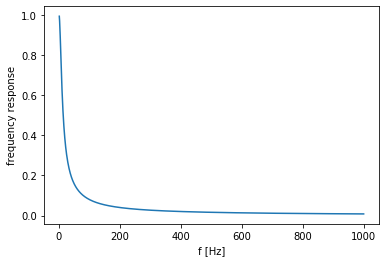

In [11]:
f = np.arange(1,1000+1)
w = 2 * pi * f
b = np.array([1])
a = np.array([tau, 1])
w1, h = freqs(b, a, worN=w)

# plot
plt.figure(figsize=(6,4))
plt.plot(f,abs(h))
plt.xlabel('f [Hz]')
plt.ylabel('frequency response')
plt.show()

 - (b) From the lecture retrieve the analytical expression of the frequency response (1)

<img src="q3b.jpg" align="left" width=600 height=600 />

 - (c) Plot and compare the modulus of both frequency responses obtained in (a) and (b). (1)

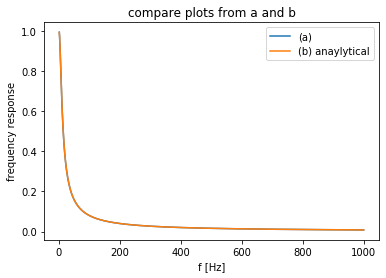

In [12]:
analytical_h = 1 / (1+1j*2*pi*f*tau)

# plot
plt.figure(figsize=(6,4))
plt.plot(f,abs(h),label='(a)')
plt.plot(f,abs(analytical_h),label='(b) anaylytical')
plt.title('compare plots from a and b')
plt.xlabel('f [Hz]')
plt.ylabel('frequency response')
plt.legend()
plt.show()

- (d) (optional) Simulate the output of the system for input $\cos(2\pi f_0 t)$ for $f_0=1,10,100,1000Hz$, for a time ranging from $0$ to $3s$, estimate the amplitude of the response in each case (use $(max(y) - min(y))/2$ over e.g. the last period of the computed output). Plot the results. Which aspect of the frequency response this amplitude should reflect? Check consistency of the results with the previous answers regarding the frequency response. (2)

In [13]:
f0 = [1, 10, 100, 1000]
t = np.arange(0, 3, dt)

Output=[]
amp=[]
for f in f0:
    Input = lambda t: np.cos(2*pi*f*t)
    y = filterOutput(t,Input,dt)
    a = 0.5*(max(y)-min(y))  # calculate amplitude
    Output.append(y)
    amp.append(a)
    

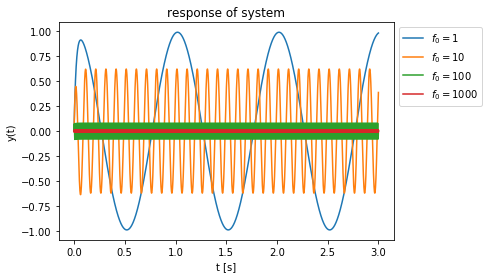

In [14]:
# plot
plt.figure(figsize=(6,4))
for i in range(len(f0)):
    plt.plot(t,Output[i], label=f'$f_0 = {f0[i]}$')
plt.title('response of system')
plt.xlabel('t [s]')
plt.ylabel('y(t)')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

In [15]:
for i in range(len(f0)):
    print(f'When f0 = {f0[i]}, amplitude of the response is {amp[i]}')

When f0 = 1, amplitude of the response is [0.99219662]
When f0 = 10, amplitude of the response is [0.63052314]
When f0 = 100, amplitude of the response is [0.0814891]
When f0 = 1000, amplitude of the response is [0.00761793]


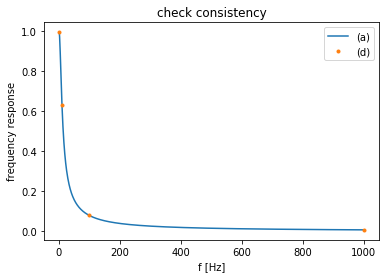

In [16]:
f = np.arange(1,1000+1)
# plot
plt.figure(figsize=(6,4))
plt.plot(f,abs(h),label='(a)')
plt.plot(f0,amp,'.',label='(d)')
plt.title('check consistency')
plt.xlabel('f [Hz]')
plt.ylabel('frequency response')
plt.legend()
plt.show()

The amplitude for $f_0=1,10,100,1000Hz$ reflects the system's response of the corresponding frequency component in the input signal. This system act as a low pass filter, amplitude of high frequency component is attenuated. 

# Part 2: Digital filters

We will now approximate the behavior of the above continuous time system based on the discretization of the impulse response.

## Finite impulse response filter
We want to define an discrete time LTI system based on a finite length discretization of continuous time impulse response. 

**Question 4:**

 - (a) Based on the outcome of Question 1, create a sequence $h_d$ of N values resulting from the sampling of the empirically estimated impulse response $h(t)$ (i.e. the response to spike(t)) of the continuous time system at times $t=0,dt,2dt,...,(N-1)dt$ with $N =200$ and $dt=.1ms$. Plot this sequence. (1)


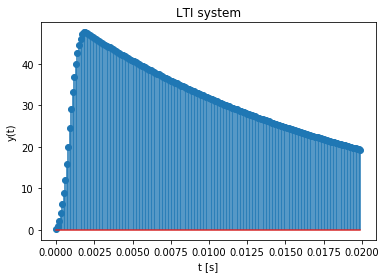

In [17]:
N = 200
t = np.arange(0,N*dt,dt)
t1 = np.arange(-0.001, dt*N-0.001, dt)

hd=filterOutput(t1,spike,dt)

# plot
plt.figure(figsize=(6,4))
plt.stem(t,hd,use_line_collection=True)
plt.xlabel('t [s]')
plt.ylabel('y(t)')
plt.title('LTI system')
plt.show()

 We will now consider the discrete time LTI system with impulse response $g[k]=\begin{cases}h_d[k]&, \text{if}\quad k\in [0\dots N-1]\\0 &,\text{otherwise.}\end{cases}$.  It approximates the contiuous time system of questions 1-3 by replacing continuous time convolution by discrete time convolution with a discretize version of the original impulse response. 

- (b) Using an approximation of convolution integrals using rectangles of width $dt$ (as done in the lectures), explain how the output (or the impulse response) of this discretized system can be rescaled to approximately match the range of values achieved by the continuous time system. (1)

<img src="q4b.jpg" align="left" width=600 height=600 />

 - (c) Check the lecture and the documentation of the function scipy.signal.lfilter to define the routine that computes the M values of the output of this discrete LTI system given M values of the input (all values taken by inputs and outputs before those are assumed to be zero). Use to simulate the response of the current clamp experiment of question 2(d), but this time in discrete time. For that you will sample the original input at $dt=.1ms$. Compare the discretized response to the response computed in question 2(d). Use normalization of the response by a multiplicative constant if necessary (see above question (c)) (2)

In [18]:
def get_hd(N):
    dt = 0.0001
    t1 = np.arange(-0.001, dt*N-0.001, dt)
    hd=filterOutput(t1,spike,dt)
    return hd

def fir(hd,x):
    # hd: h
    # x: signal
    dt=0.0001
    t = np.arange(-0.01, 0.1, dt)
    a=np.array([1])
    hd = hd.squeeze()  # reshape hd for lfilter
    r = lfilter(b=hd, a=a, x=x)
    r = r*dt  # normalization 
    return r

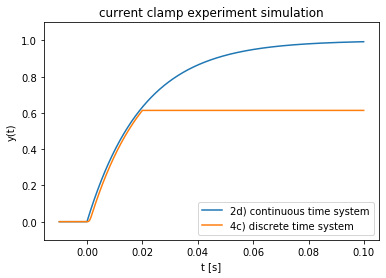

In [19]:
N = 200
t = np.arange(-0.01, 0.1, dt)
hd = get_hd(N)
r = fir(hd,x=c_clamp(t))

# plot
plt.figure(figsize=(6,4))
#plt.plot(t,c_clamp(t),label='x(t)')
plt.plot(t,analytical_y2,label='2d) continuous time system')
plt.plot(t,r,label='4c) discrete time system')
plt.ylim([-0.1,1.1])
plt.xlabel('t [s]')
plt.ylabel('y(t)')
plt.title('current clamp experiment simulation')
plt.legend()
plt.show()

 - (d) Use the routine *scipy.signal.freqz* to compute the frequency response of the discrete time LTI system defined above. Compare this response to the response of the continuous time system computed in question 2, by converting normalized frequencies to physical frequencies (in Hz) by multiplying them by the sampling frequency $1/dt$. Note again that the frequency axis of freqz is given in pulsation ($2\pi$ times normalized frequency) (1)

In [20]:
# discrete time frequency response for FIR
def DTFR1(N):
    hd = get_hd(N)
    f = np.arange(1,1000+1)
    w = 2 * np.pi * f
    a = np.array([1])
    w1, h = freqz(b=hd, a=a, worN=w,fs=2*np.pi/dt)
    h = h*dt
    return h

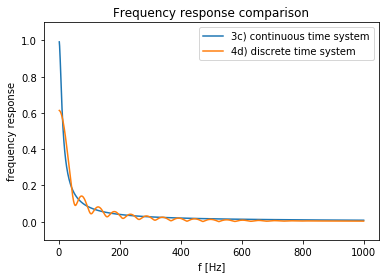

In [21]:
N = 200
f = np.arange(1,1000+1)
h = DTFR1(N)
analytical_h = 1 / (1+1j*2*pi*f*tau)  # analytical expression from q3

# plot
plt.figure(figsize=(6,4))
plt.plot(f,abs(analytical_h),label='3c) continuous time system')
plt.plot(f,abs(h),label='4d) discrete time system')
plt.xlabel('f [Hz]')
plt.ylabel('frequency response')
plt.title('Frequency response comparison')
plt.ylim([-0.1,1.1])
plt.legend()
plt.show()

 - (e) (optional) Increase N to observe how the discretized system response gets closer to the original continuous time system (reproduce plots in (d)-(e) with selected values of N = [10, 100, 500, 1000] ). (2)

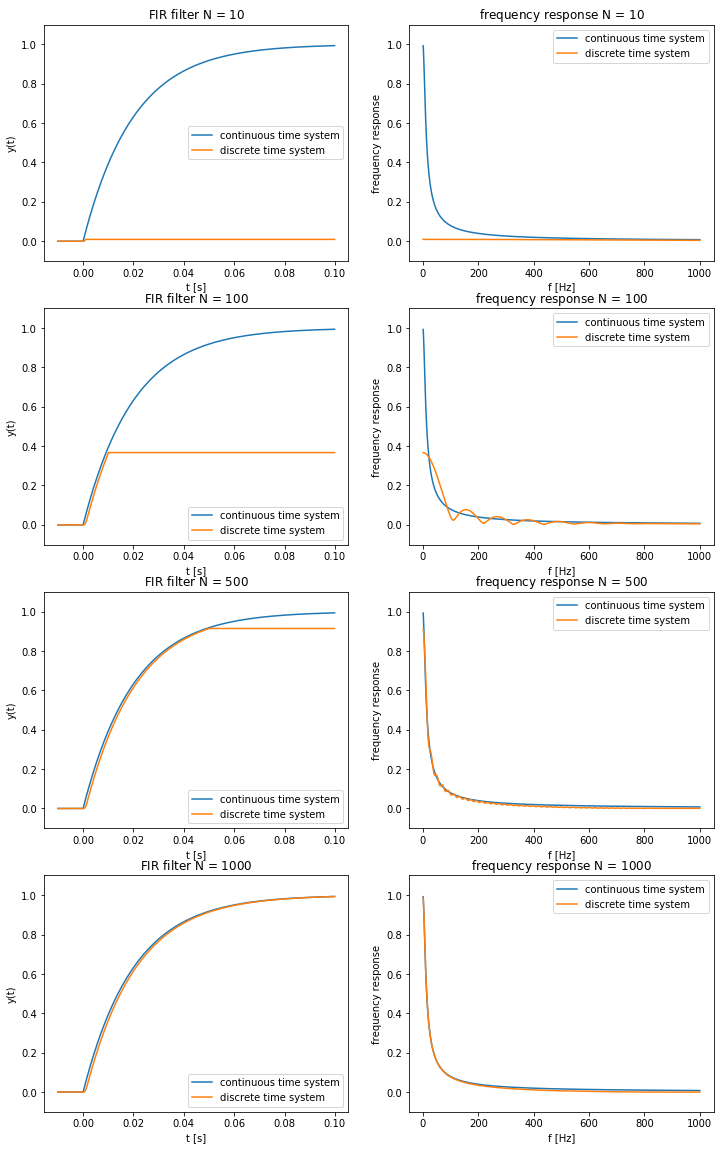

In [22]:
N=[10,100,500,1000]
dt = 0.0001
t = np.arange(-0.01, 0.1, dt)
f = np.arange(1,1000+1)
c=1

plt.figure(figsize=(12,20))
for n in N:
    plt.subplot(4,2,c)
    hd = get_hd(n)
    r = fir(hd,x=c_clamp(t))
    # plot
    plt.plot(t,analytical_y2,label='continuous time system')
    plt.plot(t,r,label='discrete time system')
    plt.ylim([-0.1,1.1])
    plt.xlabel('t [s]')
    plt.ylabel('y(t)')
    plt.title(f'FIR filter N = ${n}$')
    plt.legend()
    c +=1
    
    plt.subplot(4,2,c)
    h = DTFR1(n)
    # plot
    plt.plot(f,abs(analytical_h),label='continuous time system')
    plt.plot(f,abs(h),label='discrete time system')
    plt.ylim([-0.1,1.1])
    plt.xlabel('f [Hz]')
    plt.ylabel('frequency response')
    plt.title(f'frequency response N = ${n}$')
    plt.legend()
    c +=1

#### Infinite impluse response filter

Based on lectures and the above question 1, we know that for our synpase system, if we discretize the analytic expression of the continuous time impulse response at multiples of sampling period $dt$, the resulting sequence takes the form 

\begin{equation}
h_d[k]=\begin{cases}\alpha \rho^k\,, & k\geq 0\\ 0\,,&\text{otherwise} \end{cases}
\end{equation}

We use this property to define an discrete time approximation of the system with infinite length response. This implies that the output computation will rely on a difference equation with a feedback term involving the past output values.

**Queston 5:**

 - (a) Give the expression of $\alpha$ and $\rho$ as a function of $\tau$ (refer to the lecture/homeworks if needed, but this is immediate using question 1). (1)

<img src="q5a.jpg" align="left" width=600 height=600 />

 - (b) Based on developments shown in the lecture, show that such an $h_d$ is the impulse response of the difference equation (with input $x$ and output $y$). (1)

$$
y[n+1]=\rho y[n]+\alpha x[n]   \quad \text{I did it as: }y[n+1]=\rho y[n]+\alpha x[n+1]
$$

<img src="q5b.jpg" align="left" width=600 height=600 />

 - (c) Use the *lfilter* function to implement this filter and use it to simulate the current clamp response like in Question 4(c). (1)

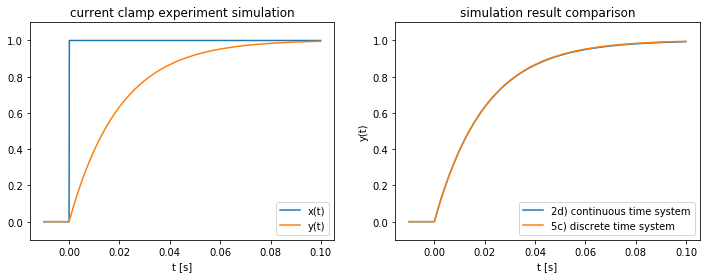

In [23]:
def iir(x,dt):
    b = np.array([1/tau])
    a = np.array([1, -np.exp(-dt/tau)])
    r = lfilter(b, a, x)
    r = r*dt
    return r

dt = 0.0001
t = np.arange(-0.01, 0.1, dt)
r = iir(x=c_clamp(t),dt = dt)

# plot
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(t,c_clamp(t),label='x(t)')
plt.plot(t,r,label='y(t)')
plt.ylim([-0.1,1.1])
plt.xlabel('t [s]')
plt.title('current clamp experiment simulation')
plt.legend()
plt.subplot(1,2,2)
plt.plot(t,analytical_y2,label='2d) continuous time system')
plt.plot(t,r,label='5c) discrete time system')
plt.ylim([-0.1,1.1])
plt.xlabel('t [s]')
plt.ylabel('y(t)')
plt.title('simulation result comparison')
plt.legend()
plt.show()


 - (d) (optional) Reproduce the Question 4(d) with this new LTI sytem. (1)

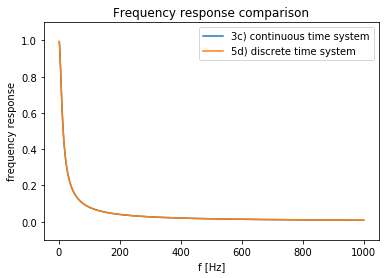

In [24]:
# discrete time frequency response for IIR
def DTFR2(dt):
    f = np.arange(1,1000+1)
    w = 2 * np.pi * f
    b = np.array([1/tau])
    a = np.array([1, -np.exp(-dt/tau)])
    w1, h = freqz(b=b, a=a, worN=w,fs=2*np.pi/dt)
    h = h*dt
    return h

dt = 0.0001
f = np.arange(1,1000+1)
h = DTFR2(dt)

# plot
plt.figure(figsize=(6,4))
plt.plot(f,abs(analytical_h),label='3c) continuous time system')
plt.plot(f,abs(h),label='5d) discrete time system')
plt.xlabel('f [Hz]')
plt.ylabel('frequency response')
plt.title('Frequency response comparison')
plt.ylim([-0.1,1.1])
plt.legend()
plt.show()


 - (e) (optional) Check how the approximation deteroriates (current clamp response and frequency response) when we use a coarser sampling period (dt=5ms,10ms). (1)

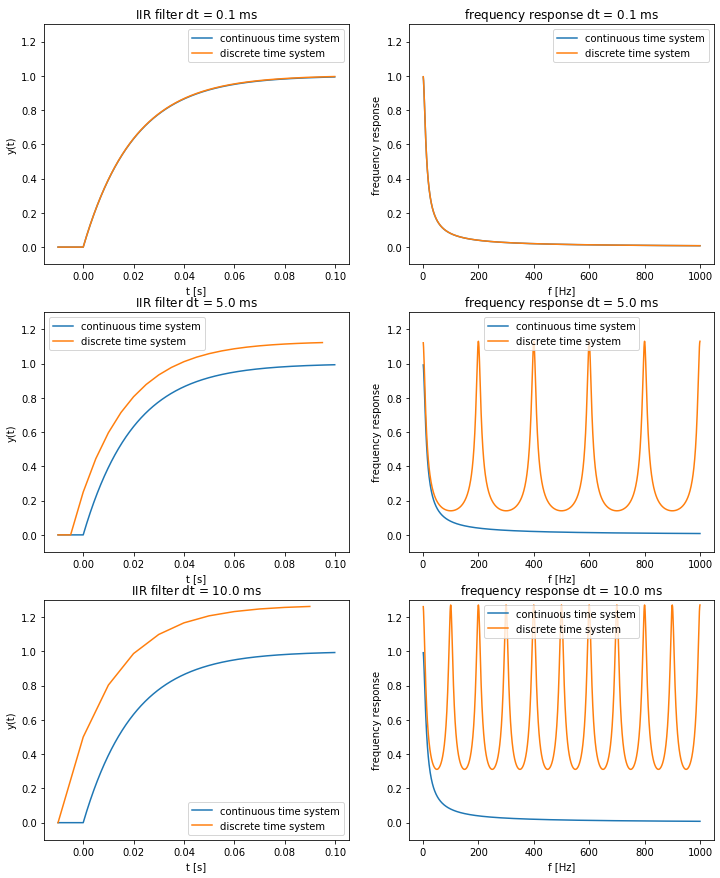

In [25]:
SP=[0.0001,0.005,0.01]  # sampling time: 0.1ms, 5ms, 10ms

c=1
plt.figure(figsize=(12,15))
tt = np.arange(-0.01, 0.1, dt)
f = np.arange(1,1000+1)
for sp in SP:
    t = np.arange(-0.01, 0.1, sp)
    
    plt.subplot(3,2,c)
    r = iir(x=c_clamp(t),dt = sp)
    # plot
    plt.plot(tt,analytical_y2,label='continuous time system')
    plt.plot(t,r,label='discrete time system')
    plt.ylim([-0.1,1.3])
    plt.xlabel('t [s]')
    plt.ylabel('y(t)')
    plt.title(f'IIR filter dt = ${sp*1000}$ ms')
    plt.legend()
    c +=1
    
    plt.subplot(3,2,c)
    h = DTFR2(dt=sp)
    # plot
    plt.plot(f,abs(analytical_h),label='continuous time system')
    plt.plot(f,abs(h),label='discrete time system')
    plt.ylim([-0.1,1.3])
    plt.xlabel('f [Hz]')
    plt.ylabel('frequency response')
    plt.title(f'frequency response dt = ${sp*1000}$ ms')
    plt.legend()
    c +=1


$\therefore$ IIR best approximate continuous time system when dt is small.